<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Found 8996 files belonging to 6 classes.
Class names: ['Asian', 'Black', 'Indian', 'Latino', 'MiddleEast', 'White']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
      

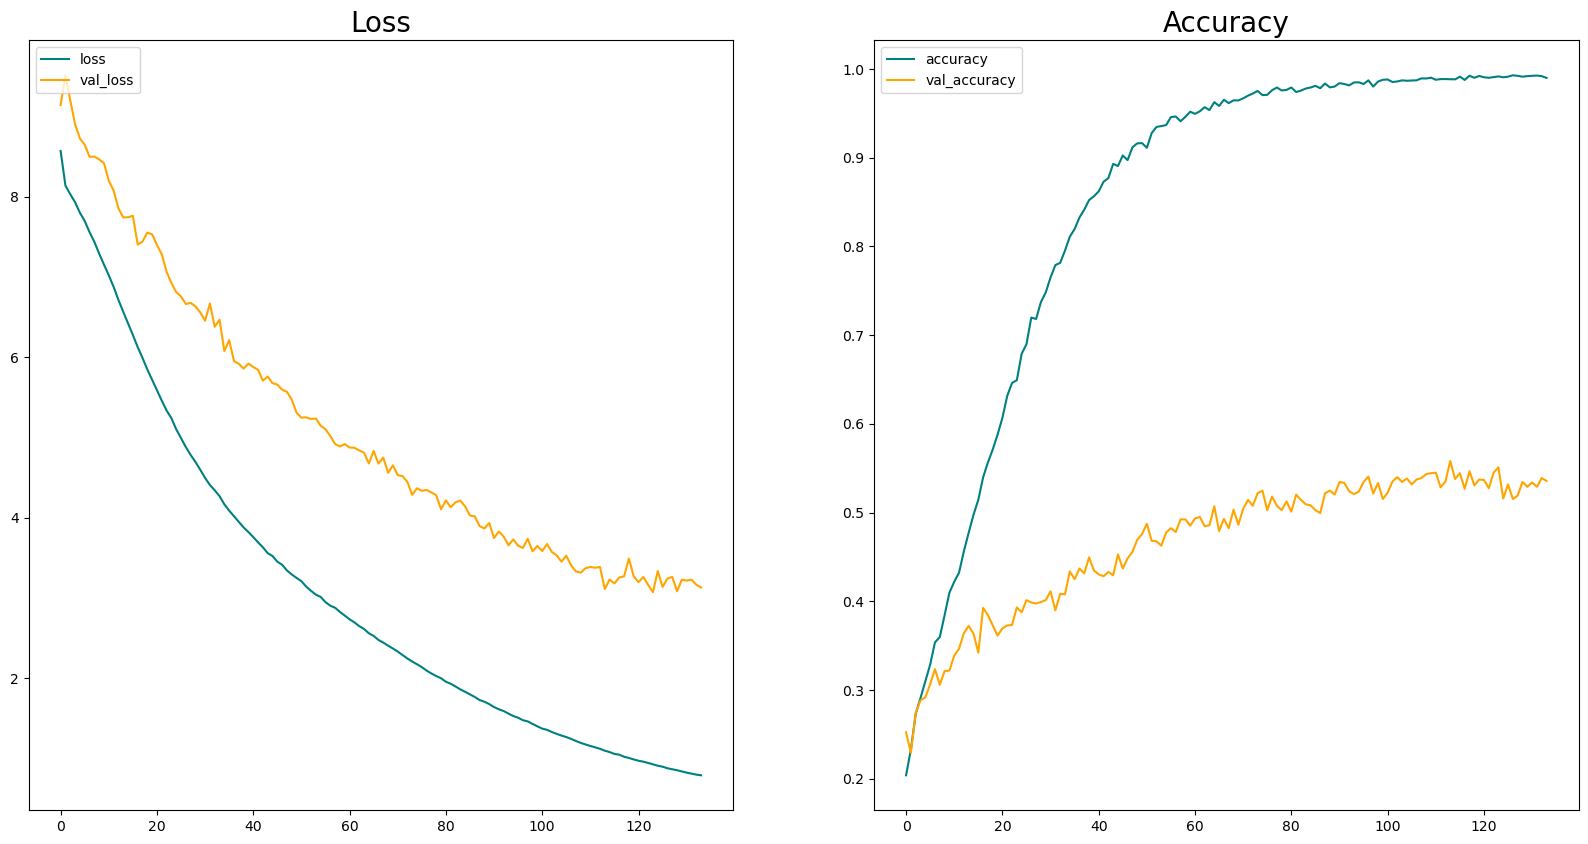

28/28 [==============================] - 2s 46ms/step


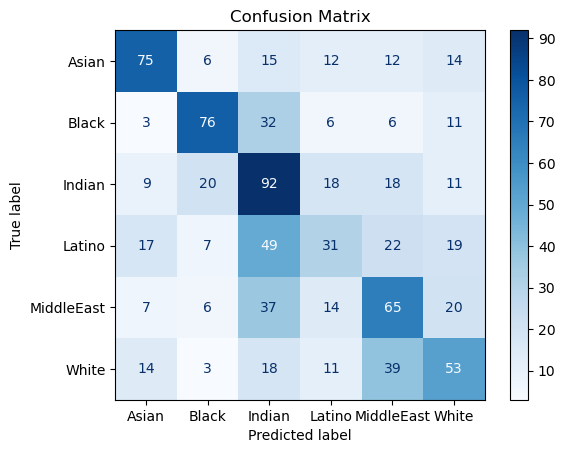

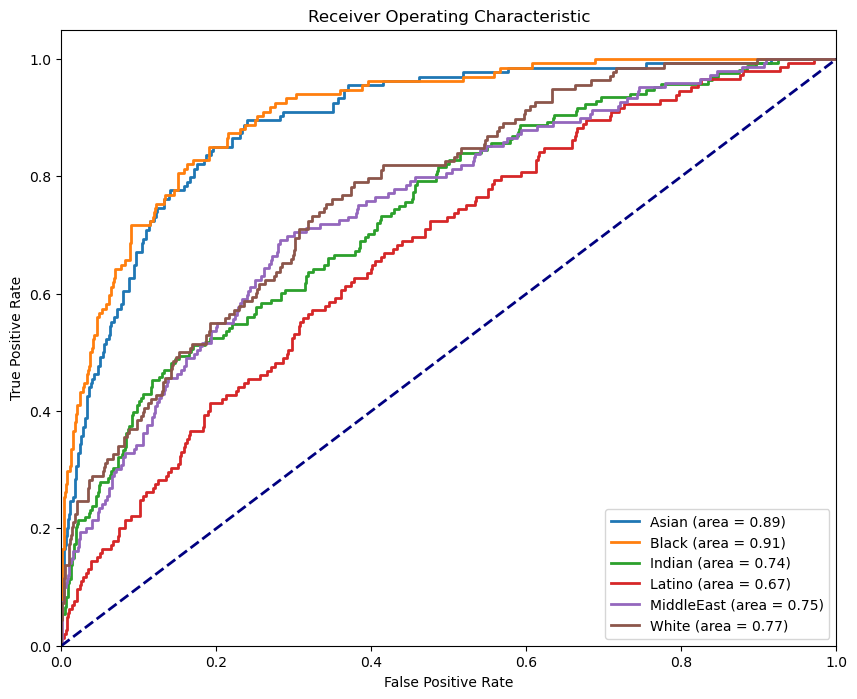

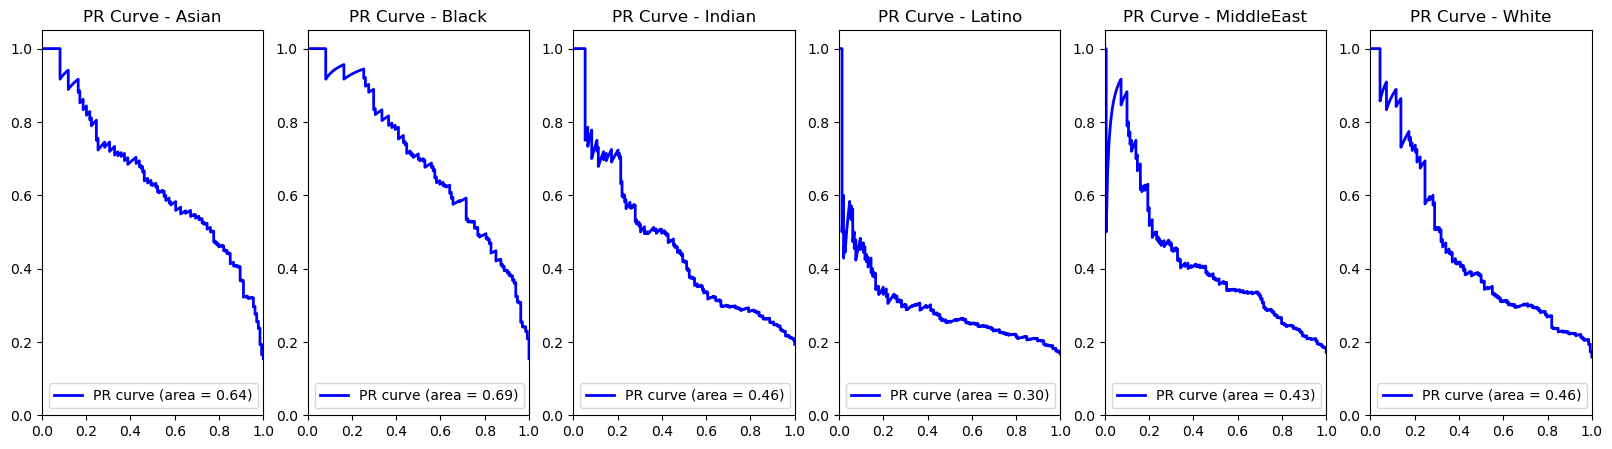

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score

# Load the dataset from the directory with categorical labels
data_dir = 'dataset1500'

# Load dataset from directory with one-hot encoded labels
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical'  # Use 'categorical' for one-hot encoded labels
)

# Access class names from the dataset
class_names = dataset.class_names
print(f"Class names: {class_names}")

# Normalize the images
data = dataset.map(lambda x, y: (x / 255.0, y))

# Split the dataset into training, validation, and test sets
data_size = len(list(data))
train_size = int(data_size * 0.7)
val_size = int(data_size * 0.2) + 1
test_size = int(data_size * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Define a simplified model with increased regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Implement Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model with Early Stopping
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=300, validation_data=val, callbacks=[early_stopping_callback, tensorboard_callback])

# Plot training history
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot loss
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend(loc="upper left")

# Plot accuracy
ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend(loc="upper left")

plt.show()

# Evaluate the model on the test set
test_images, test_labels = zip(*list(test.unbatch()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Get predictions
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot all ROC curves in the same plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (area = {roc_auc:0.2f})')

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.show()

# Plot PR curves for each class in separate plots
fig, ax = plt.subplots(1, len(class_names), figsize=(20, 5))

for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    pr_auc = average_precision_score(test_labels[:, i], predictions[:, i])
    ax[i].plot(recall, precision, color='b', lw=2, label=f'PR curve (area = {pr_auc:0.2f})')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_title(f'PR Curve - {class_names[i]}')
    ax[i].legend(loc="lower left")

plt.show()

# Save the model in both H5 and SavedModel formats
model.save('EthnicModel.h5')
